## Food vision mini

In [1]:
import tensorflow as tf 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import keras 
from keras import layers 
import os 
import datetime 
from helpers import *  
import datetime

In [2]:
scenarios = [
    {
        "scnario": "scenario_0",
        "name": "model_0",
        "experiment_name": "ten_percent_101_food", 
        "data_augmentation": False, 
        "fine_tune": False
    },
    {
        "scnario": "scenario_1",
        "name": "model_1",
        "experiment_name": "ten_percent_101_food", 
        "data_augmentation": False, 
        "fine_tune": True
    }
]

scenarios_df = pd.DataFrame(scenarios) 
scenarios_df

scnario     name       experiment_name  data_augmentation  fine_tune
0  scenario_0  model_0  ten_percent_101_food              False      False
1  scenario_1  model_1  ten_percent_101_food              False       True

In [3]:
!nvidia-smi

Thu Dec 25 01:31:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 590.44.01              Driver Version: 591.44         CUDA Version: 13.1     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5070 ...    On  |   00000000:01:00.0  On |                  N/A |
| N/A   47C    P8              7W /   86W |     373MiB /  12227MiB |      4%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
walk_data_directory("data/101_food_classes_10_percent/")

There are 2 folders and 0 in 'data/101_food_classes_10_percent/'
There are 101 folders and 0 in 'data/101_food_classes_10_percent/test'
There are 0 folders and 250 in 'data/101_food_classes_10_percent/test/apple_pie'
There are 0 folders and 250 in 'data/101_food_classes_10_percent/test/baby_back_ribs'
There are 0 folders and 250 in 'data/101_food_classes_10_percent/test/baklava'
There are 0 folders and 250 in 'data/101_food_classes_10_percent/test/beef_carpaccio'
There are 0 folders and 250 in 'data/101_food_classes_10_percent/test/beef_tartare'
There are 0 folders and 250 in 'data/101_food_classes_10_percent/test/beet_salad'
There are 0 folders and 250 in 'data/101_food_classes_10_percent/test/beignets'
There are 0 folders and 250 in 'data/101_food_classes_10_percent/test/bibimbap'
There are 0 folders and 250 in 'data/101_food_classes_10_percent/test/bread_pudding'
There are 0 folders and 250 in 'data/101_food_classes_10_percent/test/breakfast_burrito'
There are 0 folders and 250 in '

In [5]:
ten_percent_101_food_train_dir = "data/101_food_classes_10_percent/train/"
ten_percent_101_food_test_dir = "data/101_food_classes_10_percent/test/" 

ten_percent_101_train_ds, ten_percent_101_test_ds = import_and_create_train_test_ds(train_dir=ten_percent_101_food_train_dir, 
                                                                                   test_dir=ten_percent_101_food_test_dir)  



Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


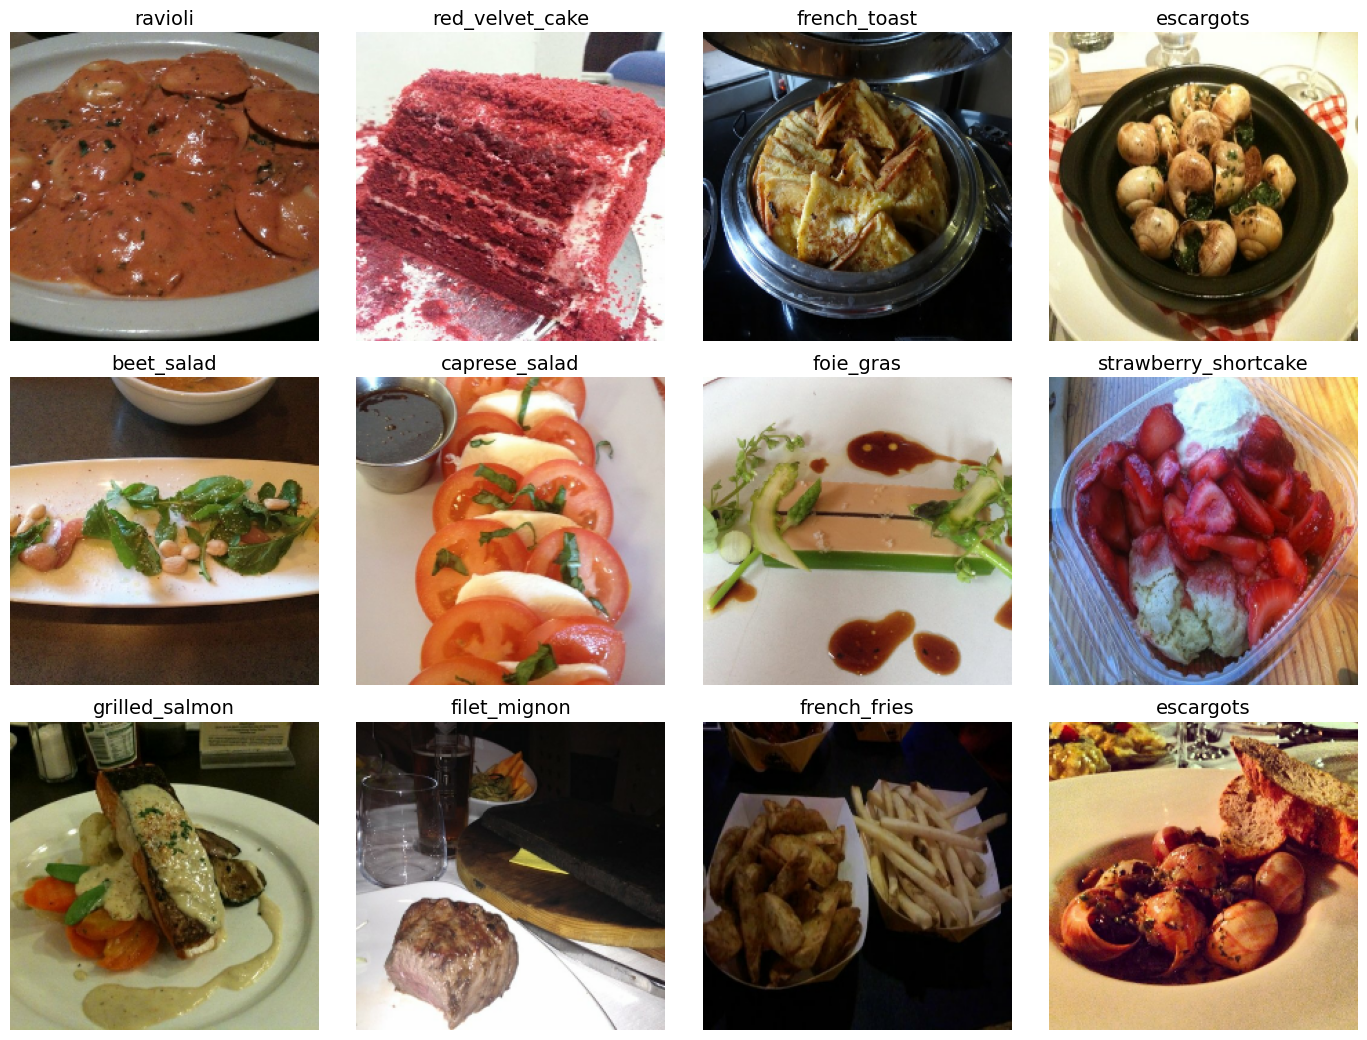

In [6]:
view_all_images_in_a_batch_ds(ten_percent_101_train_ds, max_images=12)

In [7]:
scenarios_df

scnario     name       experiment_name  data_augmentation  fine_tune
0  scenario_0  model_0  ten_percent_101_food              False      False
1  scenario_1  model_1  ten_percent_101_food              False       True

# Train big dog model with transfer learning  

1. Create a ModelCheckpoint callback
2. Create a TensorBoard callback
3. Create a data augmentation layer
4. Build a headless (no top layers) Functional EfficientNetB0 backboned-model (We will create our own output layer)
5. Compile Model
6. Fite model (validate on 15% of the data)

In [8]:
# Create ModelCheckpoint Callback & TensorBoard Callback 

def create_model_checkpoint_callback(dir_name, experiment_name): 
    checkpoint_path = os.path.join(
        dir_name, 
        experiment_name, 
        "ckpt-epoch{epoch:02d}.weights.h5"
    )

    return keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, 
        save_best_only=False, 
        save_weights_only=True, 
        save_freq='epoch'
    )

def create_tensorboard_callback(dir_name, experiment_name): 
    log_dir = os.path.join(
        dir_name,
        experiment_name,
        datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    )

    return keras.callbacks.TensorBoard(
        log_dir=log_dir
    )

In [9]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"), 
    layers.RandomRotation(0.2), 
    layers.RandomTranslation(height_factor=(-0.2, 0.2), 
                            width_factor=(-0.2, 0.2)), 
    layers.RandomBrightness(0.2), 
    layers.RandomContrast(0.2), 
    layers.RandomZoom(0.2)
], name="data_augmentation")

In [10]:
BATCH_SIZE = 32 
INPUT_SHAPE = (224, 224, 3) 
NUM_CLASS = len(ten_percent_101_test_ds.class_names) 

# 1. Create base model 

base_model = keras.applications.EfficientNetB0(include_top=False) 
base_model.trainable = False 

# 2. Create inputs & outputs  
inputs = keras.Input(shape=INPUT_SHAPE, name="input_layer") 
x = data_augmentation(inputs) 
x = base_model(x, training=False) 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2d")(x) 
x = layers.Dropout(0.2)(x) 
outputs = layers.Dense(NUM_CLASS, activation="softmax", name="output_layer")(x) 

# 3. Create model 
model_0 = keras.Model(inputs, outputs, name="ten_percent_101_food") 

# 4. Compile model 
model_0.compile(
    loss=keras.losses.CategoricalCrossentropy(),  
    optimizer=keras.optimizers.Adam(), 
    metrics=["accuracy"]
)

model_0.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "ten_percent_101_food"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_2d       │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [11]:
history_0 = model_0.fit(
    ten_percent_101_train_ds,
    validation_data=ten_percent_101_test_ds, 
    validation_steps=int(0.15 * (len(ten_percent_101_test_ds))) , 
    epochs=5, 
    callbacks=[
        create_tensorboard_callback(
            dir_name="logs/tensorboard",
            experiment_name= "ten_percent_101_food"
        ), 
        create_model_checkpoint_callback(
            dir_name="logs/model_checkpoints/", 
            experiment_name="ten_percent_101_food"
        )
    ], 
    verbose=2
)

Epoch 1/5
237/237 - 35s - 149ms/step - accuracy: 0.1498 - loss: 3.9117 - val_accuracy: 0.3379 - val_loss: 2.9193
Epoch 2/5
237/237 - 17s - 73ms/step - accuracy: 0.3138 - loss: 3.0073 - val_accuracy: 0.4264 - val_loss: 2.3904
Epoch 3/5
237/237 - 18s - 74ms/step - accuracy: 0.3748 - loss: 2.6635 - val_accuracy: 0.4592 - val_loss: 2.1987
Epoch 4/5
237/237 - 17s - 73ms/step - accuracy: 0.4051 - loss: 2.4733 - val_accuracy: 0.4876 - val_loss: 2.0498
Epoch 5/5
237/237 - 17s - 73ms/step - accuracy: 0.4272 - loss: 2.3445 - val_accuracy: 0.4883 - val_loss: 1.9969


In [12]:
results_scenario_0 = model_0.evaluate(ten_percent_101_test_ds)

790/790 ━━━━━━━━━━━━━━━━━━━━ 74s 94ms/step - accuracy: 0.4974 - loss: 1.9838


In [13]:
results_scenario_0

[1.9888477325439453, 0.4942970275878906]

In [11]:
model_0.load_weights("logs/model_checkpoints/ten_percent_101_food/ckpt-epoch05.weights.h5") 

In [15]:
np.isclose(np.array(results_scenario_0), np.array(model_0.evaluate(ten_percent_101_test_ds)))

790/790 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step - accuracy: 0.4982 - loss: 1.9801


array([ True,  True])

In [16]:
model_0.summary()

Model: "ten_percent_101_food"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_2d       │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,437,716 (16.93 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 258,764 (1010.80 KB)

In [12]:
## Prepare model for fine tuning  
model_0.layers[2].trainable = True 

for layer in model_0.layers[2].layers[:-10]: 
    layer.trainable = False
print(f"Number of trainable layers in base_model : {len(model_0.layers[2].trainable_variables)}")


model_0.compile(
    loss=keras.losses.CategoricalCrossentropy(), 
    optimizer=keras.optimizers.Adam(learning_rate=1e-4), 
    metrics=['accuracy']
)
for i, layer in enumerate(model_0.layers): 
    print(i, layer.name, layer.trainable)

Number of trainable layers in base_model : 10
0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2d True
4 dropout True
5 output_layer True


In [18]:
model_0.summary()

Model: "ten_percent_101_food"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_2d       │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 1,022,613 (3.90 MB)

 Non-trainable params: 3,156,339 (12.04 MB)

In [19]:
initial_epochs = 5 
epochs = 5 

history_1 = model_0.fit(
    ten_percent_101_train_ds,
    validation_data=ten_percent_101_test_ds, 
    validation_steps=int(0.15 * (len(ten_percent_101_test_ds))) , 
    callbacks=[
        create_tensorboard_callback(
            dir_name="logs/tensorboard",
            experiment_name= "ten_percent_101_food_fine"
        ), 
        create_model_checkpoint_callback(
            dir_name="logs/model_checkpoints/", 
            experiment_name="ten_percent_101_food_fine"
        )
    ],
    initial_epoch=initial_epochs,
    epochs=initial_epochs + 5, 
    verbose=2
)

Epoch 6/10
237/237 - 31s - 133ms/step - accuracy: 0.4809 - loss: 2.1627 - val_accuracy: 0.5429 - val_loss: 1.7499
Epoch 7/10
237/237 - 19s - 78ms/step - accuracy: 0.5255 - loss: 1.9270 - val_accuracy: 0.5617 - val_loss: 1.6713
Epoch 8/10
237/237 - 18s - 78ms/step - accuracy: 0.5431 - loss: 1.8209 - val_accuracy: 0.5781 - val_loss: 1.6103
Epoch 9/10
237/237 - 19s - 79ms/step - accuracy: 0.5699 - loss: 1.7242 - val_accuracy: 0.5771 - val_loss: 1.5691
Epoch 10/10
237/237 - 19s - 80ms/step - accuracy: 0.5721 - loss: 1.6750 - val_accuracy: 0.5877 - val_loss: 1.5445


In [20]:
results_scenario_1 = model_0.evaluate(ten_percent_101_test_ds)

790/790 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.5907 - loss: 1.5376


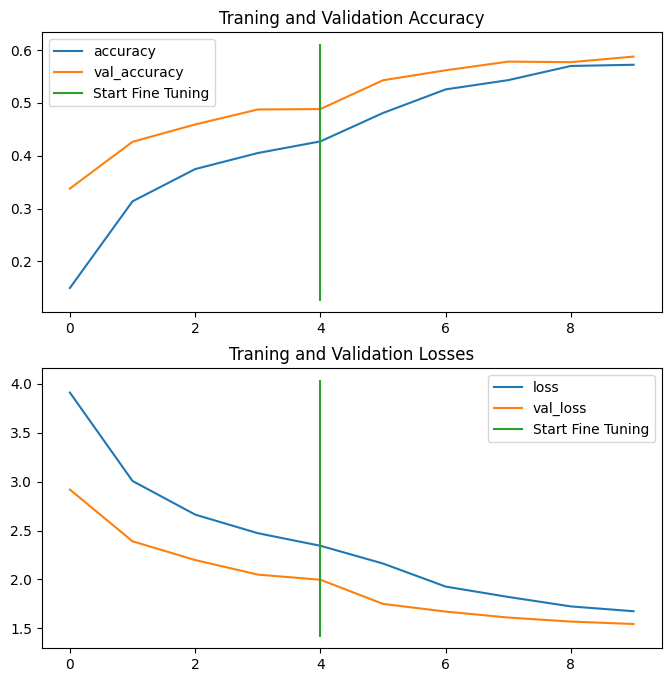

In [21]:
compare_history(original_history=history_0, 
               new_history=history_1)

In [22]:
keras.Model.save(model_0, "models/ten_percent_101_food_model.keras")

In [13]:
loaded_model = keras.models.load_model("models/ten_percent_101_food_model.keras")

In [14]:
loaded_model_results = loaded_model.evaluate(ten_percent_101_test_ds)

790/790 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.5911 - loss: 1.5355


In [28]:
np.isclose(np.array(results_scenario_1), np.array(loaded_model_results))

array([ True,  True])

# Evaluate the performance of the big dog model accross all different classes 

In [11]:
loaded_model = tf.keras.models.load_model("models/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/")

loaded_model.compile(
    optimizer="Adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

loaded_model.summary()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 5070 Ti Laptop GPU, compute capability 12.0
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
   

In [12]:
results_downloaded_model = loaded_model.evaluate(ten_percent_101_test_ds)
results_downloaded_model

790/790 [==============================] - 39s 36ms/step - loss: 1.1964 - accuracy: 0.7868


[1.1964080333709717, 0.786811888217926]

In [13]:
# Make predictions with trained model
preds_probs = loaded_model.predict(ten_percent_101_test_ds)

790/790 [==============================] - 20s 24ms/step


In [14]:
# How many predictions are there? 
len(preds_probs)

25250

In [15]:
# Shape of preds_probs 
preds_probs.shape

(25250, 101)

In [16]:
preds_probs[:10]

array([[2.8145200e-04, 9.4814468e-06, 3.2210476e-03, ..., 2.9082369e-07,
        1.9043995e-04, 3.2210476e-03],
       [9.9971002e-01, 2.7777872e-10, 2.5163054e-05, ..., 2.8334201e-08,
        1.6752202e-09, 4.3023213e-10],
       [5.9240550e-01, 2.0933475e-09, 1.3932042e-02, ..., 3.5812950e-10,
        1.9031474e-06, 1.4653424e-04],
       ...,
       [9.4967175e-01, 1.4428797e-11, 7.3473548e-06, ..., 4.4631090e-09,
        5.6334129e-06, 2.2891383e-07],
       [8.6214244e-01, 1.5327918e-05, 2.2975318e-02, ..., 6.0024986e-06,
        3.3670965e-06, 2.6373138e-07],
       [8.4385119e-04, 3.2319161e-09, 1.2102205e-08, ..., 2.8079372e-09,
        1.0825563e-09, 2.5875653e-07]], dtype=float32)

In [17]:
preds_probs[0], len(preds_probs[0]), sum(preds_probs[1])

(array([2.81451998e-04, 9.48144680e-06, 3.22104758e-03, 6.52631282e-09,
        2.10355101e-05, 2.07093854e-05, 1.01507442e-06, 8.56065996e-10,
        8.31970538e-05, 3.52278512e-05, 8.15635246e-07, 5.60577348e-07,
        1.21051009e-04, 1.55013524e-09, 2.64399685e-04, 1.31438859e-02,
        6.21808431e-06, 9.53574215e-07, 1.08509412e-04, 6.38854871e-08,
        3.13982397e-04, 1.59023550e-08, 2.55189684e-06, 1.15507668e-04,
        3.20753206e-05, 3.25804322e-05, 1.62891927e-04, 3.12664929e-06,
        1.85637728e-05, 1.97908001e-08, 1.58118098e-07, 8.49911430e-06,
        1.04572112e-03, 1.12594962e-05, 5.80809101e-05, 3.20753206e-05,
        5.25821582e-04, 1.46235351e-07, 4.20103827e-03, 7.07570289e-04,
        1.83529756e-03, 3.22589995e-06, 8.54778364e-07, 3.95245524e-06,
        4.15959104e-04, 1.00354810e-04, 3.18926875e-04, 8.41526230e-07,
        4.39078143e-08, 4.26719477e-03, 2.48754702e-07, 3.17588683e-06,
        3.86320278e-02, 6.20873179e-03, 4.48546489e-09, 9.373782

In [19]:
pred_classes = np.argmax(preds_probs, axis=1)
pred_classes[:10]

array([85,  0,  0,  0,  0,  0,  0,  0,  0, 41])

In [75]:
prediced_class_probas = np.max(preds_probs, axis=1)

In [21]:
class_names = ten_percent_101_train_ds.class_names

In [22]:
class_names[48]

'greek_salad'

In [23]:
ten_percent_101_test_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [24]:
# Get actual classes/labels from test_ds
y_labels = [] 
for images, labels in ten_percent_101_test_ds.unbatch(): 
    y_labels.append(labels.numpy().argmax())

y_labels[:10]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [25]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns 

sklearn_accuracy = accuracy_score(y_labels, pred_classes)

In [26]:
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

In [27]:
results_downloaded_model

[1.1964080333709717, 0.786811888217926]

In [28]:
## Create a cconfusion_matrix 

import itertools
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()
  ax.tick_params(axis="x", labelrotation=90)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")
  
# Make a function to predict on images and plot them (works with multi-class)

In [29]:
make_confusion_matrix(y_true=y_labels, 
                     y_pred=pred_classes, 
                     classes=class_names, 
                      figsize=(100, 100),
                      text_size=20
                     )

In [30]:
class_names[16:18]

['cheese_plate', 'cheesecake']

In [31]:
class_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
class_report_df = pd.DataFrame(class_report_dict).T[:101]
class_report_df["classname"] = class_names

In [34]:
class_report_sorted = class_report_df.sort_values("f1-score", ascending=True)

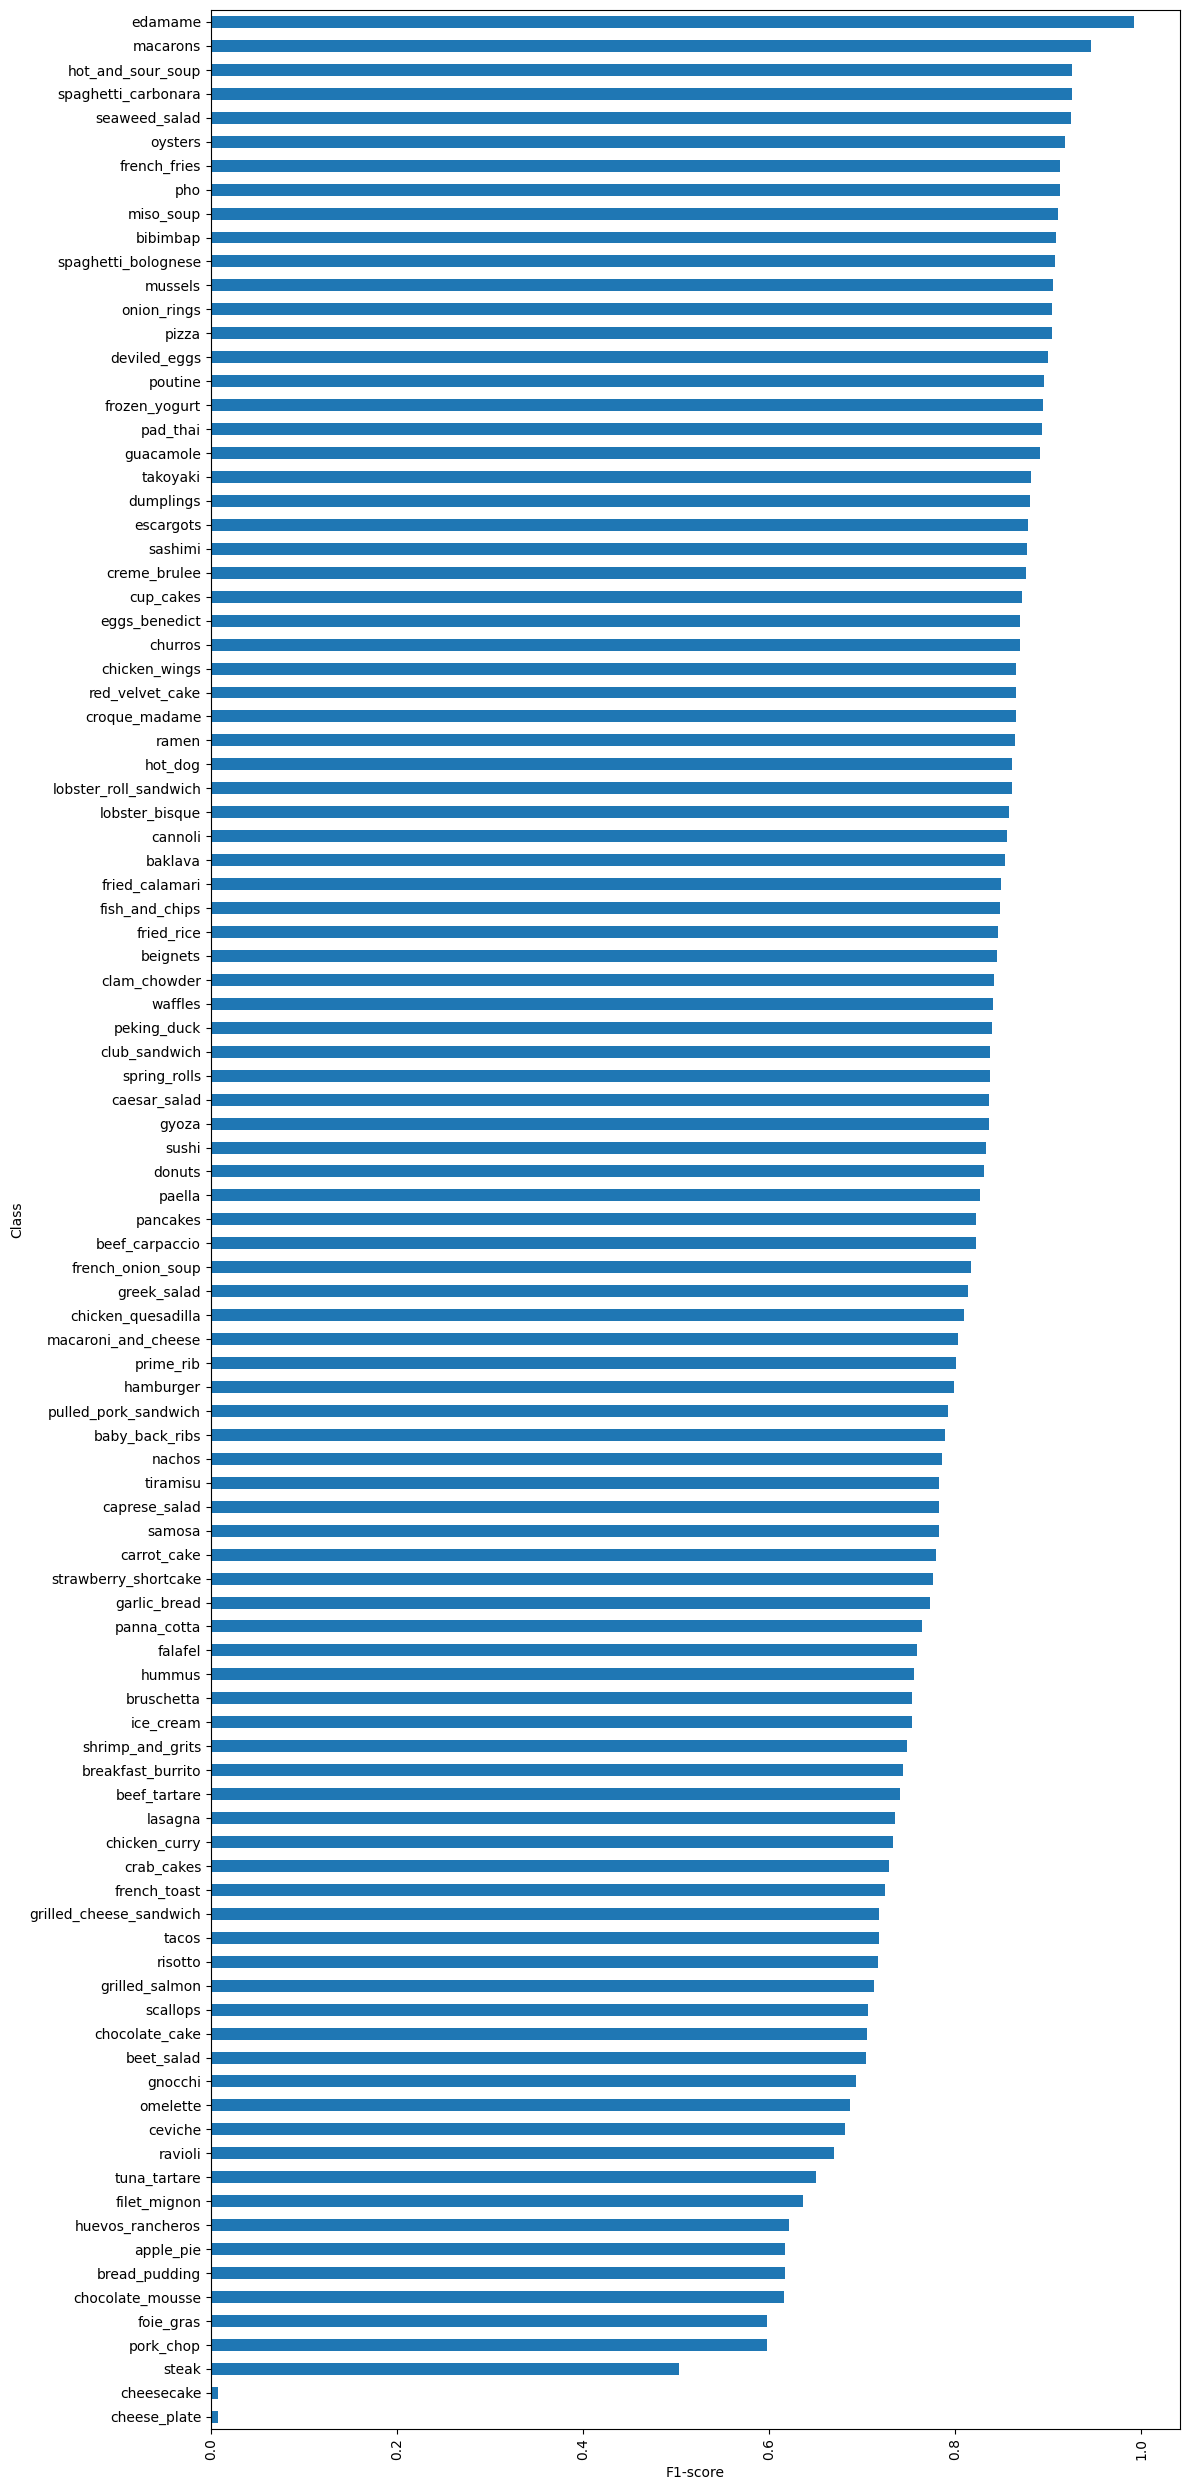

In [35]:
ax = class_report_sorted[["classname", "f1-score"]].plot(
    kind="barh", x="classname", legend=False, figsize=(12, 25)
)

ax.set_xlabel("F1-score")
ax.set_ylabel("Class")

# Rotate class names vertically
plt.setp(ax.get_xticklabels(), rotation=90, ha="center")

plt.tight_layout()


In [45]:
# Visualizing predictions on custom images 

img_path = "data/custom_food_images/hamburger.jpeg" 

def load_and_preprocess_image(img_path): 




img = load_and_preprocess_image(img_path=img_path)
img.shape

TensorShape([1, 224, 224, 3])

In [41]:
pred_probas = loaded_model.predict(img)

1/1 [==============================] - 4s 4s/step


In [43]:
pred_class = pred_probas.argmax(axis=1)
pred_class

array([53])

In [47]:
pred_probas.max(axis=1)[0]

0.9986274

In [44]:
class_names[pred_class[0]]

'hamburger'

In [64]:
def predict_and_display_an_image(model, img_path, class_names, scale=False): 
    
    img = tf.io.read_file(img_path) 
    img = tf.image.decode_image(img, channels=3) 
    img_raw = tf.image.resize(img, size=(224, 224))
    img = tf.cast(img_raw, tf.float32)

    if scale: 
        img = img/255.
    img = tf.expand_dims(img, axis=0)

    pred_probas = model.predict(img)
    pred_class = pred_probas.argmax(axis=1)
    confidence = pred_probas.max(axis=1)[0] 
    predicted_label = class_names[pred_class[0]]

    plt.figure(figsize=(7, 7))

    plt.imshow(tf.cast(img_raw, tf.uint8))
    plt.title(f"{predicted_label} : {confidence:.2%}")
    plt.axis("off")
    plt.show()
    
    

1/1 [==============================] - 0s 24ms/step


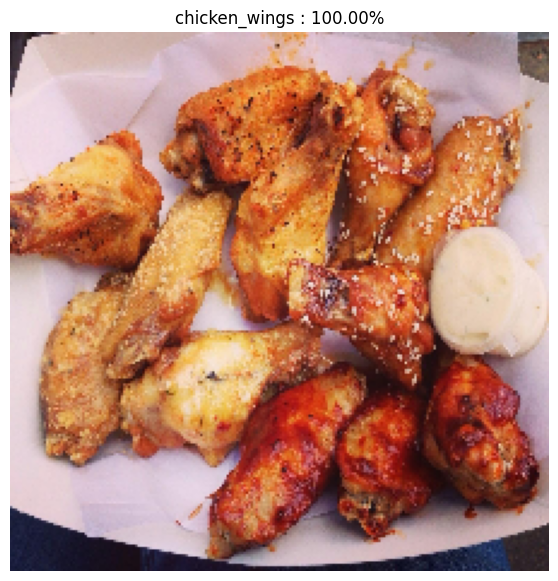

In [109]:
img_path = "data/custom_food_images/chicken_wings.jpeg"
predict_and_display_an_image(model=loaded_model, 
                            img_path=img_path, 
                            class_names=class_names)

# Find Wrong predictions with highest probability. 

1. Get all the image file paths in test dataset using **list_files()** method. 
2. Crate a Pandas DataFrame of the image file paths, ground truth labesl, predicted classes from our model, max prediction probabilities.
3. Use DataFrame to find all the wrong predictions where gt!= predicted class
4. Sort dataframe based on the wrong predictions (have the highes predicted probability pred at the top)
5. Visualize images with the highest pred probas and have wrong prediction.

In [71]:
import os 
from os.path import isfile, join 

def build_image_df_os(root_dir): 
    records = []
    for folder in os.listdir(root_dir): 
        label=folder 
        folder_path = os.path.join(root_dir, folder)
        for file in os.listdir(folder_path):
            filepath = os.path.join(folder_path, file) 

            records.append({
                "filepath": filepath, 
                "label": label
            })

    return pd.DataFrame(records) 

df = build_image_df_os(ten_percent_101_food_test_dir)

df[:5]


filepath      label
0  data/101_food_classes_10_percent/test/apple_pi...  apple_pie
1  data/101_food_classes_10_percent/test/apple_pi...  apple_pie
2  data/101_food_classes_10_percent/test/apple_pi...  apple_pie
3  data/101_food_classes_10_percent/test/apple_pi...  apple_pie
4  data/101_food_classes_10_percent/test/apple_pi...  apple_pie

In [73]:
predicted_labels = []
for pred_class in pred_classes: 
    predicted_labels.append(class_names[pred_class]) 

print(predicted_labels[:5])

df['predicted_classes'] = pred_classes 
df['pred_prob'] = prediced_class_probas
df["predicted_label"] = predicted_labels

wrong_predictions = df[df["label"] != df["predicted_label"]].sort_values("pred_prob", ascending=False) 
wrong_predictions[:10]

['samosa', 'apple_pie', 'apple_pie', 'apple_pie', 'apple_pie']

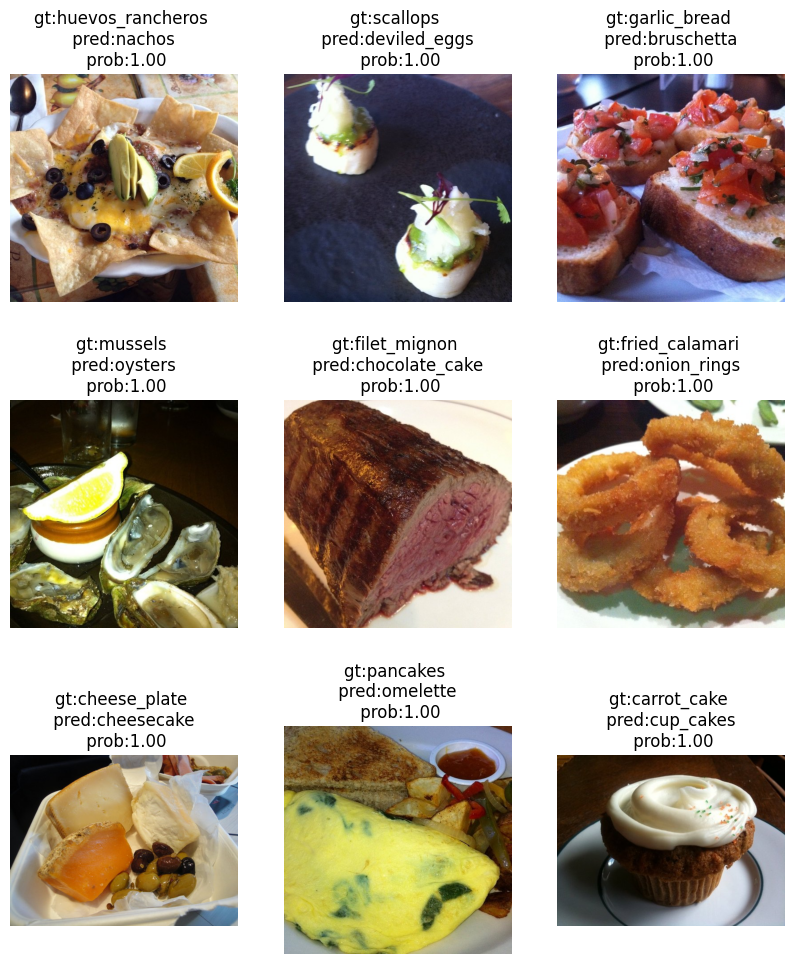

In [92]:
import math 
def plot_n_number_of_wrong_preds_with_hoghes_probas(dataframe, n): 
    file_paths = dataframe['filepath'][:n].tolist()
    gt_labels = dataframe['label'][:n].tolist() 
    pred_labels = dataframe['predicted_label'][:n].tolist() 
    pred_probabilities = dataframe['pred_prob'][:n].tolist() 
    row_num = math.ceil(n/3)

    plt.figure(figsize=(10, row_num*3))

    

    for i in range(n): 
        plt.subplot(row_num, 3, i+1) 
        img = plt.imread(file_paths[i]) 
        plt.imshow(img) 
        plt.title(f"gt:{gt_labels[i]} \n pred:{pred_labels[i]} \n prob:{pred_probabilities[i]:.2f}")
        plt.axis("off")
    plt.show();  

plot_n_number_of_wrong_preds_with_hoghes_probas(dataframe=wrong_predictions, 
                                               n=9)
    

In [83]:
wrong_predictions[:5]

filepath             label  \
14035  data/101_food_classes_10_percent/test/huevos_r...  huevos_rancheros   
21978  data/101_food_classes_10_percent/test/scallops...          scallops   
11642  data/101_food_classes_10_percent/test/garlic_b...      garlic_bread   
16271  data/101_food_classes_10_percent/test/mussels/...           mussels   
9416   data/101_food_classes_10_percent/test/filet_mi...      filet_mignon   

       predicted_classes  pred_prob predicted_label  
14035                 66   1.000000          nachos  
21978                 30   1.000000    deviled_eggs  
11642                 10   1.000000      bruschetta  
16271                 69   0.999999         oysters  
9416                  21   0.999997  chocolate_cake

In [97]:
!pwd

/workspace/tensorflow_htv/04_tensorflow_transfer_learning


In [106]:
## Option 2 

filepaths = [] 

for filepath in ten_percent_101_test_ds.list_files("data/101_food_classes_10_percent/test/*/*.jpg",
                                                  shuffle=False): 
    filepaths.append(filepath.numpy())
filepaths[:10]

[b'data/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'data/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'data/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'data/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'data/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'data/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'data/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'data/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'data/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'data/101_food_classes_10_percent/test/apple_pie/1113017.jpg']